In [1]:
import numpy 
import os
import ast
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib import pyplot as plt

from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.examples.utils_example import (
    wavg,
    collapse,
    dataframe_by_group,
    graph_builder_bar)
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.calibration import get_inflators_by_year_energy
from openfisca_france_indirect_taxation.almost_ideal_demand_system.utils import add_niveau_vie_decile

from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Reform_carbon_tax import carbon_tax_rv
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Simulation_taxe_energie_winners_losers import (
    simulate_reformes_energie,
    run_all_elasticities,
    graph_winners_losers,
    graph_net_transfers,
    graph_effort_rate
    )

In [2]:
data_path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data"
output_path = os.path.join(data_path,'donnees_simulations')
elasticite = True
replique_gouv = True

In [3]:
df_elasticities = pd.read_csv(os.path.join(data_path,'Reform_parameters/Elasticities_literature.csv'), sep = ";")
df_elasticities = df_elasticities.astype({'ref_elasticity': str, 'elas_price_1_1': float , 'elas_price_2_2' : float ,'elas_price_3_3' : float })

# exemple
elasticites = df_elasticities[df_elasticities['ref_elasticity'] == 'Douenne (2020)'] 

In [10]:
to_graph, menages_reform = run_all_elasticities(df_elasticities, year = 2019, reform = carbon_tax_rv)

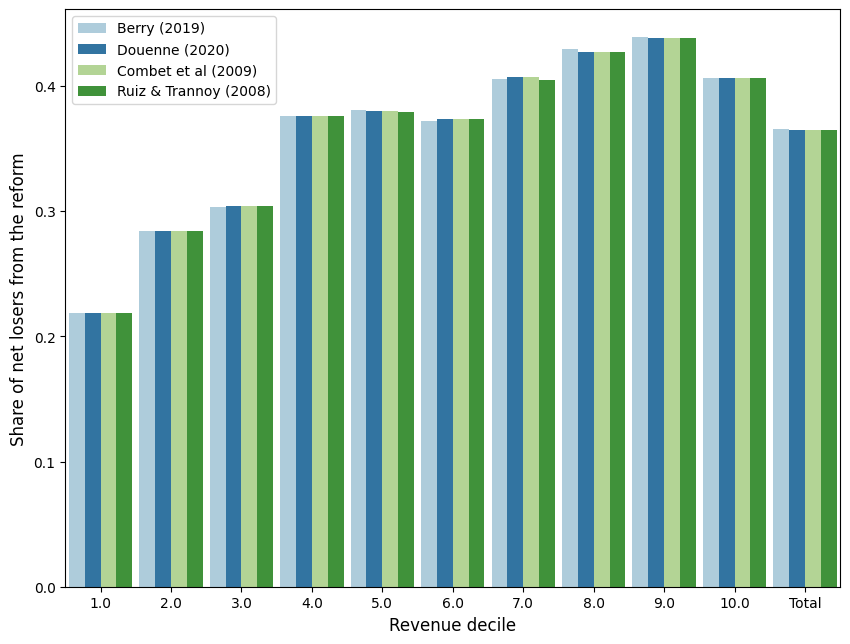

In [11]:
graph_winners_losers(to_graph,carbon_tax_rv,elas_vect= False)

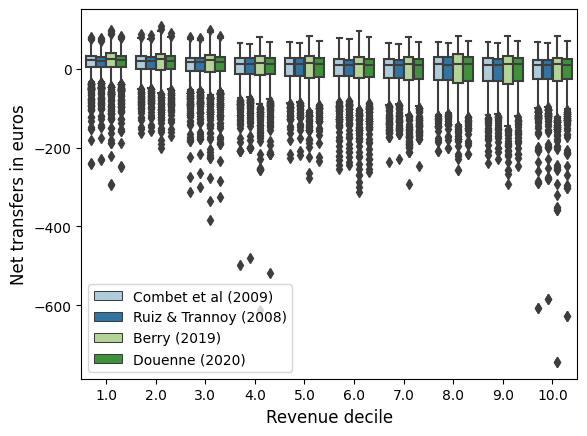

In [7]:
#graph pas pondéré
sns.boxplot(data = menages_reform, x = "niveau_vie_decile", y = "Net_transfers_reform", hue = "ref_elasticity", palette = sns.color_palette("Paired"))
plt.xlabel('Revenue decile', fontdict = {'fontsize' : 12})
plt.ylabel('Net transfers in euros', fontdict = {'fontsize' : 12})
plt.legend()

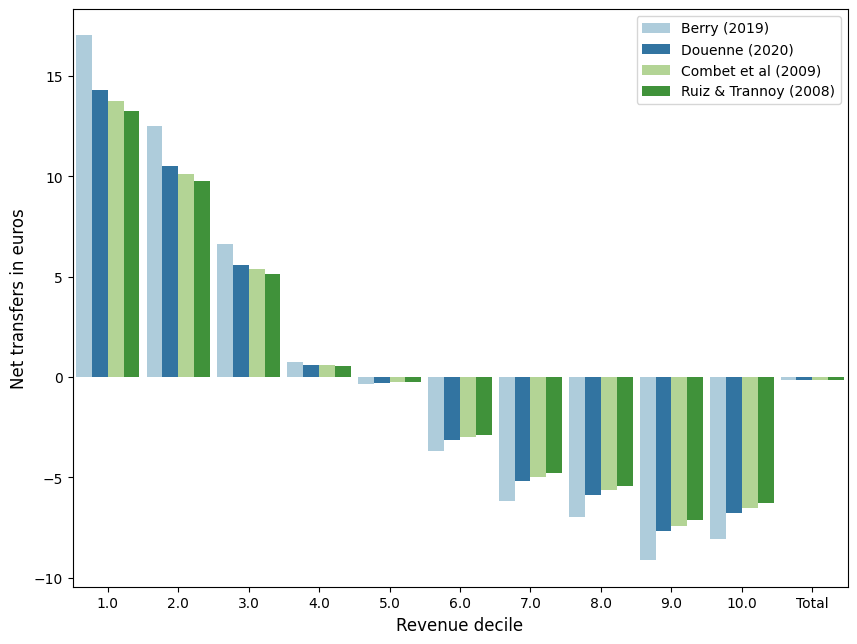

In [12]:
graph_net_transfers(to_graph,carbon_tax_rv,elas_vect = False)

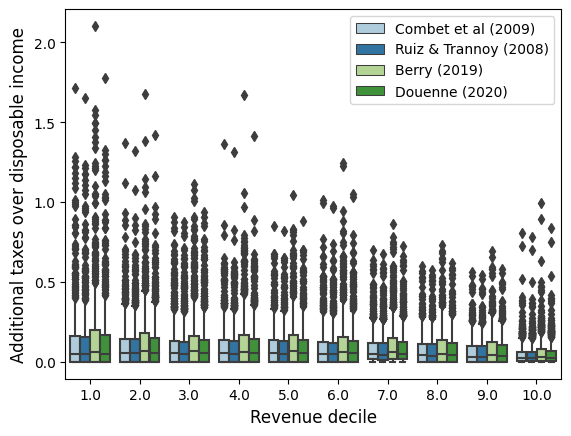

In [9]:
sns.boxplot(data = menages_reform, x = "niveau_vie_decile", y = "Effort_rate", hue = "ref_elasticity", palette = sns.color_palette("Paired"))
plt.xlabel('Revenue decile', fontdict = {'fontsize' : 12})
plt.ylabel('Additional taxes over disposable income', fontdict = {'fontsize' : 12})
plt.legend()

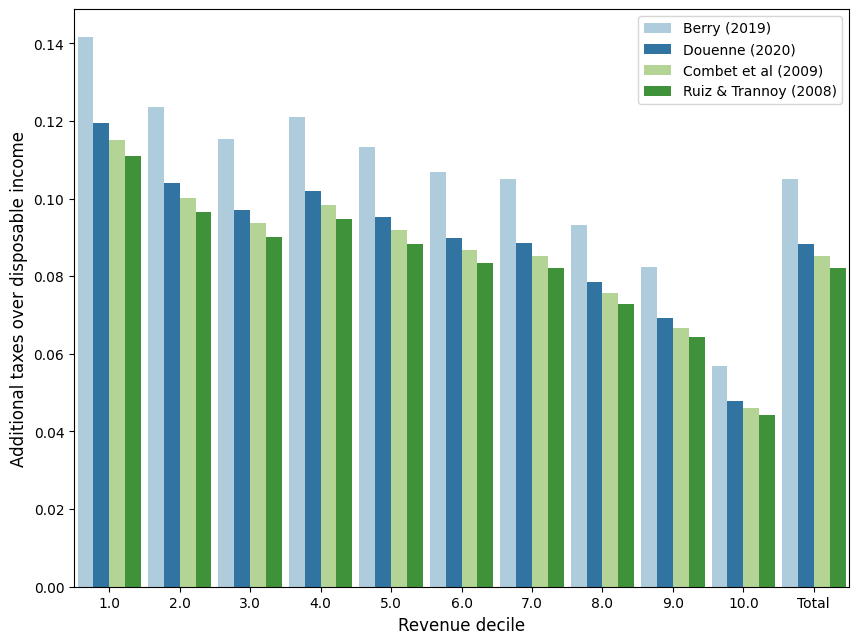

In [13]:
graph_effort_rate(to_graph,carbon_tax_rv,elas_vect = False)

In [4]:
df_elas_vect = pd.read_csv(os.path.join(data_path,'Reform_parameters/Elasticities_Douenne_20.csv'), index_col = [0])
df_elas_vect = pd.melt(frame = df_elas_vect , id_vars = ["niveau_vie_decile",'ref_elasticity'], var_name = 'strate_2', value_name = 'elas_price_1_1')

In [5]:
to_graph, menages_reform = simulate_reformes_energie(elas_vect = True, elasticites = df_elas_vect, year = 2019, reform = carbon_tax_rv)

In [6]:
to_graph_douenne, menages_reform_douenne = simulate_reformes_energie(elas_vect = False, elasticites = elasticites, year = 2019, reform = carbon_tax_rv)

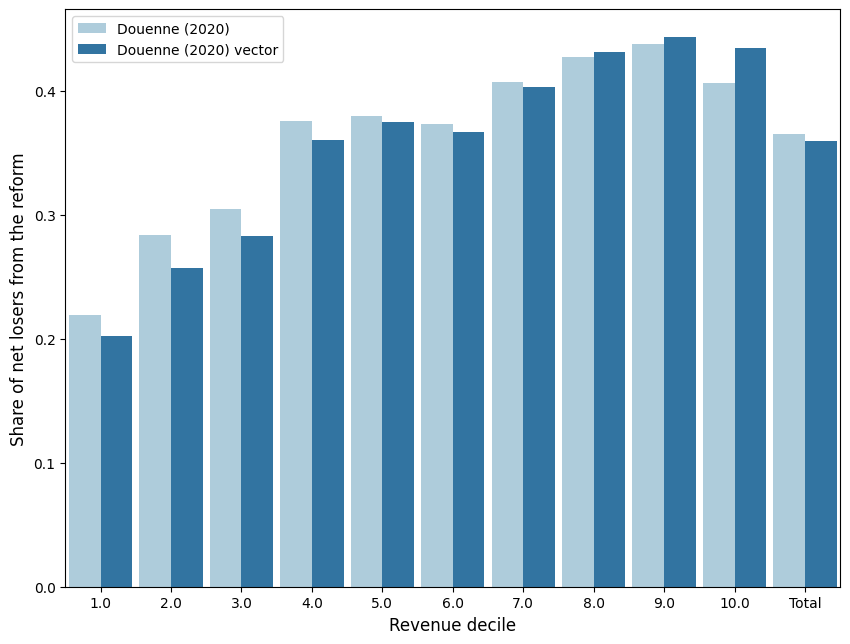

In [7]:
to_graph = pd.concat([to_graph, to_graph_douenne])
graph_winners_losers(to_graph,carbon_tax_rv,elas_vect=True)

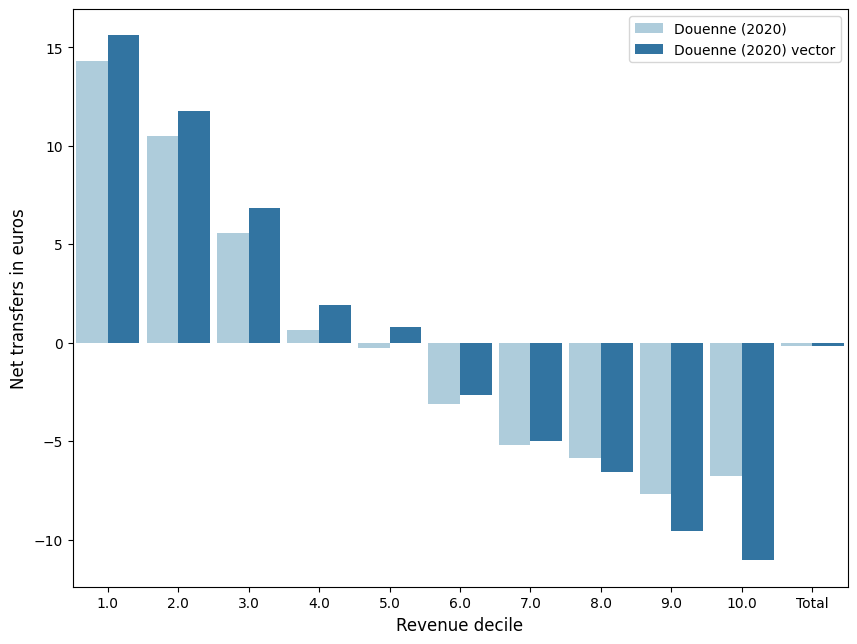

In [8]:
graph_net_transfers(to_graph,carbon_tax_rv,elas_vect=True)

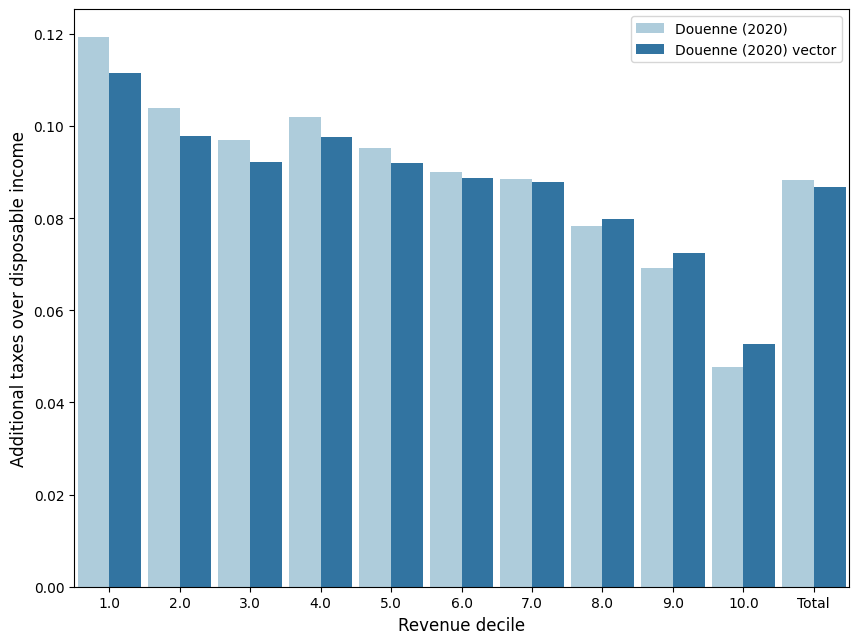

In [9]:
graph_effort_rate(to_graph,carbon_tax_rv,elas_vect=True)